## Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from srs.analysis import read_data, plot_missing_values, plot_max_median, plot_correlation_between_stations, \
    remove_outliers, interpolate_missing_values, calculate_mean_value_across_all_stations, save_mean_data, \
    plot_change_between_consecutive_hours, plot_diff_between_stations

## Read data

In [3]:
data = read_data('NO2')
stations = data.columns.tolist()[1:]

In [4]:
stations

['WpPoznDabrow', 'WpPoznPolank', 'WpPoznRatajeMOB']

In [5]:
data

Time  WpPoznDabrow  WpPoznPolank  WpPoznRatajeMOB
0    2020-01-01 00:00:00       7.66924      10.67060          6.23578
1    2020-01-01 01:00:00       7.71120       9.75276          6.42007
2    2020-01-01 02:00:00       6.89488      10.31820          8.62896
3    2020-01-01 03:00:00       6.11999       8.71542          7.09883
4    2020-01-01 04:00:00       5.61862       7.75577          6.68403
...                  ...           ...           ...              ...
8779 2020-12-31 19:00:00      39.19170      34.09650         31.63240
8780 2020-12-31 20:00:00      34.34220      32.04020         29.21060
8781 2020-12-31 21:00:00      31.55540      28.89520         25.04300
8782 2020-12-31 22:00:00      28.54990      27.10900         22.29820
8783 2020-12-31 23:00:00      27.42870      22.56940         19.91560

[8784 rows x 4 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Time             8784 non-null   datetime64[ns]
 1   WpPoznDabrow     8680 non-null   float64       
 2   WpPoznPolank     8691 non-null   float64       
 3   WpPoznRatajeMOB  8767 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 274.6 KB


In [7]:
data.describe().T

count       mean        std      min       25%      50%  \
WpPoznDabrow     8680.0  17.546581  14.626655  0.39090  7.791665  13.4350   
WpPoznPolank     8691.0  18.871996  12.316829  1.70297  9.860840  15.7685   
WpPoznRatajeMOB  8767.0  15.608125  10.372555  1.37983  7.948345  12.9442   

                     75%       max  
WpPoznDabrow     22.8573  133.7770  
WpPoznPolank     24.8480  104.5760  
WpPoznRatajeMOB  20.3219   82.5256

### Investigate missing values

In [8]:
data.isnull().mean().round(3)

Time               0.000
WpPoznDabrow       0.012
WpPoznPolank       0.011
WpPoznRatajeMOB    0.002
dtype: float64

In [9]:
plot_missing_values(data, stations)

The missing values are spread throught the whole data range, these should be easy to interpolate.

## EDA

**Maximum and median values**

In [10]:
plot_max_median(data, stations)

It looks like there are just moments throughout the day when the concentration is very high, but it does not last long.

**Correlation between stations**

The data has to be transformed for the pattern to occur.

In [11]:
data_log = data.copy()

for s in stations:
    data_log[s] = np.log(data[s])

In [12]:
plot_correlation_between_stations(data_log, stations[0], stations[1])

In [13]:
plot_correlation_between_stations(data_log, stations[0], stations[2])

In [14]:
plot_correlation_between_stations(data_log, stations[1], stations[2])

What's interesting, the measurements of stations are not linearly correlated. I had to make logarytmic transformation to see the pattern.

**Change between consecutive hours**

In [15]:
plot_change_between_consecutive_hours(data, stations)

                Difference                             
                      mean   median       max       std
Parameter                                              
WpPoznDabrow     -0.000270 -0.16783  88.58559  7.465643
WpPoznPolank     -0.003810 -0.12390  65.86550  6.169938
WpPoznRatajeMOB   0.002148 -0.18695  52.74940  5.075096


This distribution is not surprising after the observation we made when analysing max and median values. There rapid changes in pollution which happen from time to time.

**Difference between stations**

In [16]:
plot_diff_between_stations(data, stations[0], stations[1])

mean       1.311703
median     1.860150
max       79.558600
std        8.104917
Name: Difference, dtype: float64


In [17]:
plot_diff_between_stations(data, stations[0], stations[2])

mean      -1.966617
median    -0.817400
max       41.001800
std        7.911377
Name: Difference, dtype: float64


In [18]:
plot_diff_between_stations(data, stations[1], stations[2])

mean      -3.274138
median    -2.529060
max       44.062900
std        6.950824
Name: Difference, dtype: float64


There is a factor which disturbes the normal distribution and skews it towards one side.

## Remove outliers

As there are many sudden changes in data, removing outliers is more tricky here. I will increase the threshold to not remove valuable information.

In [27]:
data_rm_outliers = remove_outliers(data, stations, num_std=6)
data_rm_outliers = interpolate_missing_values(data_rm_outliers, stations)

36 outliers removed for WpPoznDabrow
2 outliers removed for WpPoznPolank
0 outliers removed for WpPoznRatajeMOB
132 values interpolated for WpPoznDabrow
95 values interpolated for WpPoznPolank
11 values interpolated for WpPoznRatajeMOB


The interploation filled missing data only up to 3 concurrent hours and this limit was chosen based on intuiton of the analyst.

How many missing values are left?

In [28]:
data.isnull().sum()

Time                 0
WpPoznDabrow       104
WpPoznPolank        93
WpPoznRatajeMOB     17
dtype: int64

In [29]:
data_rm_outliers.isnull().sum()

Time               0
WpPoznDabrow       8
WpPoznPolank       0
WpPoznRatajeMOB    6
dtype: int64

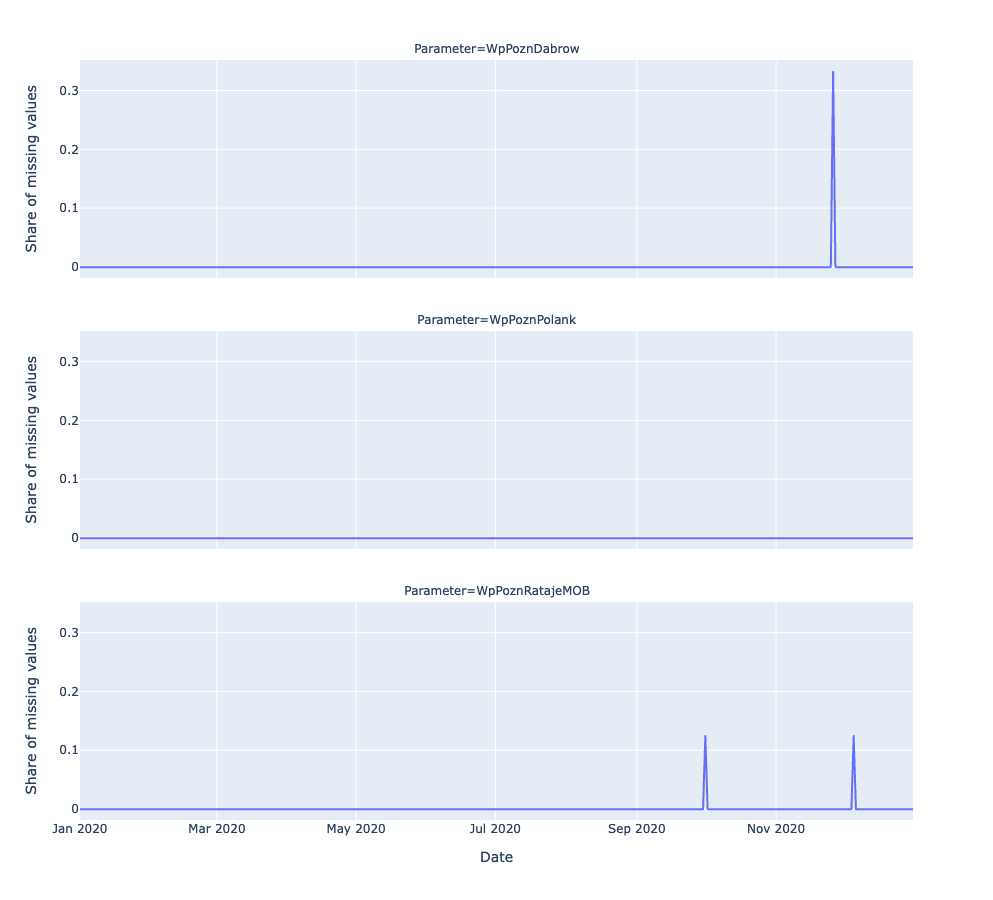

In [30]:
plot_missing_values(data_rm_outliers, stations)

## Calculate final mean value across all the stations

In [31]:
data_mean = calculate_mean_value_across_all_stations(data_rm_outliers, 'NO2')

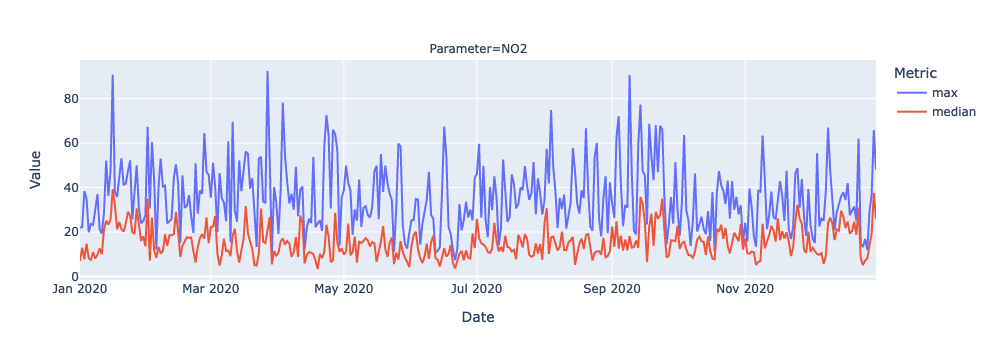

In [32]:
plot_max_median(data_mean, ['NO2'])

In [33]:
data_mean.isnull().sum()

Time    0
NO2     0
dtype: int64

With data from both stations we covered the entire year.

**Save mean data**

In [34]:
save_mean_data(data_mean, 'NO2')